# 缺失值

# 1. 查看与分析每列的缺失情况

泰坦尼克号数据集是用于分类任务的一个经典数据集，包含了乘客的基本信息，以预测他们是否在沉船事故中生还。以下是各属性的详细解释：

1. **PassengerId**：乘客的唯一ID，用来区分每位乘客。
2. **Survived**：生还标记，表示该乘客是否幸存。0表示未幸存，1表示幸存。
3. **Pclass**：乘客舱位等级（1 = 一等舱，2 = 二等舱，3 = 三等舱），反映了乘客的社会经济地位。
4. **Name**：乘客的姓名，包括头衔，有时可以反映出乘客的年龄段或社会地位。
5. **Sex**：乘客的性别（male 或 female），在当时可能影响生还的几率。
6. **Age**：乘客的年龄，单位是岁。部分乘客年龄缺失，需要数据处理。
7. **SibSp**：乘客的兄弟姐妹或配偶的数量。
8. **Parch**：乘客的父母或子女的数量。
9. **Ticket**：船票号码，可以表示某些家庭或朋友组团出行的情况。
10. **Fare**：船票费用，表示乘客为该次旅行支付的票价金额。
11. **Cabin**：乘客的舱房号码，部分缺失较多，可能对生还率有一定影响。
12. **Embarked**：乘客的登船地点（C = Cherbourg, Q = Queenstown, S = Southampton），反映了乘客从哪里登船。

该数据集常用于机器学习项目中，进行特征工程、分类模型训练等任务。

In [136]:
import pandas as pd
import numpy as np

# 载入数据
df = pd.read_csv("../input/titanic.csv")

# 查看每列的缺失值数量和比例
missing_data = df.isnull().sum()
missing_percentage = (df.isnull().sum() / len(df)) * 100
missing_info = pd.DataFrame({"Missing Values": missing_data, "Percentage": missing_percentage})
print(df.describe())
print(missing_info)


       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200  
             Missing Values  Percentage
PassengerId               0    0.000000
S

由上可猜测：Cabin与Age的缺失比例较高，可能是MAR，而Embarked的缺失比例较低，可能是MCAR。

## 1.1 探索性数据分析，使用countplot(柱状图)查看缺失值与其他变量的关系

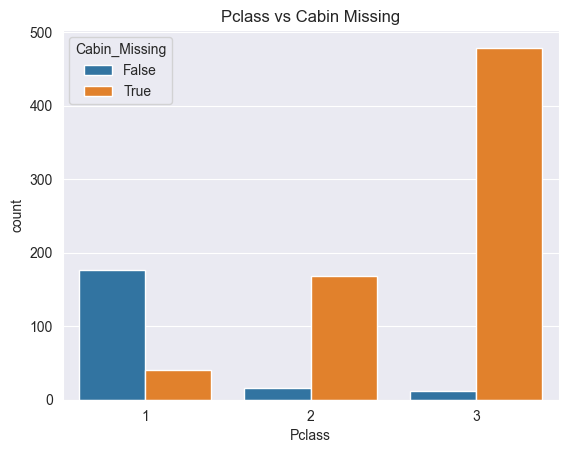

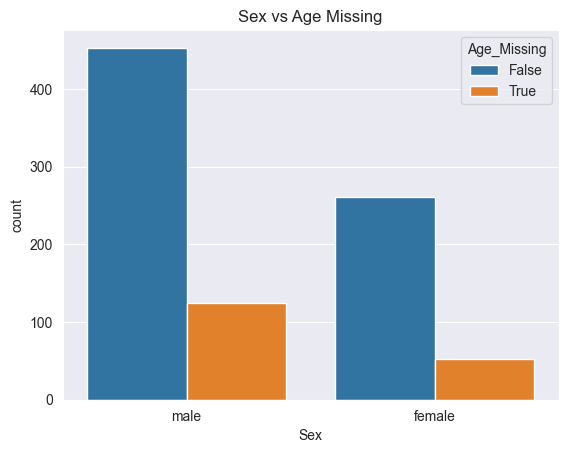

In [137]:
import matplotlib.pyplot as plt
import seaborn as sns

# 添加一个新的列，标记 Cabin 是否缺失
df['Cabin_Missing'] = df['Cabin'].isnull()

# 查看 Cabin 缺失是否与 Pclass 有关
sns.countplot(data=df, x='Pclass', hue='Cabin_Missing')
plt.title('Pclass vs Cabin Missing')
plt.show()

# 添加一个新的列，标记 Age 是否缺失
df['Age_Missing'] = df['Age'].isnull()

# 查看 Age 缺失是否与 Sex 有关
sns.countplot(data=df, x='Sex', hue='Age_Missing')
plt.title('Sex vs Age Missing')
plt.show()

# 删除添加的列，防止对后续操作产生影响
df.drop(['Cabin_Missing', 'Age_Missing'], axis=1, inplace=True)


## 1.2 卡方检验，分析缺失值与其他特征之间的关联性

### 1.2.1 检验特征与Survived之间的卡方统计量，反映出它们之间是否存在显著的关联性
这里只是为了展示卡方的用法

In [138]:
import pandas as pd
from scipy.stats import chi2_contingency

# 假设df是已经加载的DataFrame
# 检查MCAR：缺失值是否与任何变量无关
chi2 = pd.DataFrame()
chi2["feature"] = df.columns.drop('Survived')  # 不包括Survived列

for col in df.columns.drop('Survived'):
    # 只对分类变量进行卡方检验
    if df[col].dtype == 'object' or df[col].nunique() < 10:  # 假设如果一个变量的唯一值少于10，我们可以将其视为分类变量
        contingency_table = pd.crosstab(df[col], df['Survived'])
        chi2_stat, p, dof, expected = chi2_contingency(contingency_table, correction=False)
        chi2.loc[chi2['feature'] == col, 'chi2'] = chi2_stat

# 打印卡方检验结果
print(chi2.sort_values('chi2', ascending=False))

        feature        chi2
2          Name  891.000000
7        Ticket  766.569703
3           Sex  263.050574
9         Cabin  161.250000
1        Pclass  102.888989
5         SibSp   37.271793
6         Parch   27.925784
10     Embarked   26.489150
0   PassengerId         NaN
4           Age         NaN
8          Fare         NaN


### 1.2.2 检验缺失值与其他特征之间的关联性

In [139]:
import pandas as pd
from sklearn.feature_selection import chi2
from sklearn.preprocessing import LabelEncoder

# 加载数据，为了与df区分，这里使用data
data = df.copy()

# 创建缺失指示列：1表示缺失，0表示非缺失
data['Cabin_missing'] = data['Cabin'].isnull().astype(int)
data['Age_missing'] = data['Age'].isnull().astype(int)
data['Embarked_missing'] = data['Embarked'].isnull().astype(int)

# 对类别型特征进行数值编码（非缺失列）
label_encoder = LabelEncoder()
for col in ['Sex', 'Embarked', 'Pclass']:
    data[col] = label_encoder.fit_transform(data[col].astype(str))

# 提取缺失指示列
missing_indicators = ['Cabin_missing', 'Age_missing', 'Embarked_missing']
# 提取除缺失指示列以外的其他特征
other_features = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Fare', 'Survived']

# 对每个缺失指示列计算与其他特征的卡方值
for missing_col in missing_indicators:
    chi2_scores, p_values = chi2(data[other_features], data[missing_col])
    
    print(f"缺失列 {missing_col} 的卡方检验结果：")
    for i, feature in enumerate(other_features):
        print(f"  特征 {feature}: Chi2 Score = {chi2_scores[i]}, p-value = {p_values[i]}")
    print("\n")


缺失列 Cabin_missing 的卡方检验结果：
  特征 Pclass: Chi2 Score = 250.25337204173917, p-value = 2.2866642390118644e-56
  特征 Sex: Chi2 Score = 6.188823226686482, p-value = 0.012855964700506392
  特征 SibSp: Chi2 Score = 3.3875267482407603, p-value = 0.06569141762457692
  特征 Parch: Chi2 Score = 2.073096696937185, p-value = 0.1499168508147953
  特征 Fare: Chi2 Score = 15860.072301159715, p-value = 0.0
  特征 Survived: Chi2 Score = 55.13766950126406, p-value = 1.1237643485514007e-13


缺失列 Age_missing 的卡方检验结果：
  特征 Pclass: Chi2 Score = 14.217091985499028, p-value = 0.0001628842942473838
  特征 Sex: Chi2 Score = 0.957294617756041, p-value = 0.3278694394103006
  特征 SibSp: Chi2 Score = 0.7436971733481337, p-value = 0.38847910954707143
  特征 Parch: Chi2 Score = 23.339463961057998, p-value = 1.3578524634488305e-06
  特征 Fare: Chi2 Score = 692.1424241543516, p-value = 1.5289714016373752e-152
  特征 Survived: Chi2 Score = 4.666609194971476, p-value = 0.030754590494090333


缺失列 Embarked_missing 的卡方检验结果：
  特征 Pclass: Chi2 S

在这个输出中，卡方检验的结果通过两个关键指标表示：

1. **Chi2 Score**（卡方值）：表示两个特征之间的关联程度。卡方值越大，说明这两个特征之间的关联越强。
2. **p-value**（p值）：表示结果的显著性水平。p值越小，表明在统计上越不可能是由于随机性导致的关联，一般p值小于0.05被认为有显著性关联。

> **拒绝原假设**：
准确定义：p值：在原假设$H_0$为真时，得到当前观测结果或**更极端**的结果的概率。%\alpha%：在$H_0$为真时，但检验后拒绝$H_0$的概率，即犯**第I类**错误的概率。
如果p-value ≤ α，则可以拒绝原假设，认为样本数据足够强烈地反驳原假设，一般取α=0.05。“P值是犯第I类错误的实际概率，而α是犯第一类错误的最大概率”(本句不严格，但可以帮助理解，出处：https://zhuanlan.zhihu.com/p/52476581 ，更好的是p 值衡量当前数据在原假设下的罕见性，α是我们愿意容忍的第 I 类错误概率的上限，控制了判断的严格性。)。在卡方检验中，原假设$H_0$是两个变量独立，即没有关联。

### 结果分析
对于每个缺失列（如`Cabin_missing`），计算它与其他特征之间的卡方值和p值：
- **高卡方值和低p值**：如果某个特征与缺失列的卡方值较高，且p值较低（<0.05），可以认为该特征与缺失情况**有**较强的关联性。
- **低卡方值和高p值**：当卡方值较低，且p值较高（>0.05），说明该特征与缺失情况之间可能不存在显著关联。

### 输出中卡方值较大且p值较低的特征
1. Cabin_missing：Pclass、Fare
2. Age_missing：Fare
3. Embarked_missing：Fare

这说明这些特征与缺失列之间可能存在较强的关联性。

### 卡方检验的原理

卡方检验的目的是通过观察频数的差异，来判断两个分类变量是否相关。其具体计算方法如下：

1. **构建列联表**：假设我们有两个分类变量A和B，我们可以统计A的每种类别与B的每种类别的共同出现次数，形成一个列联表。
2. **计算期望频数**：假设A和B不相关，根据行列的总计数，计算出期望的频数。即，如果A和B独立，预计每个类别组合的出现次数是多少。
3. **计算卡方值**：卡方值反映了实际频数和期望频数之间的偏离程度。具体公式如下：

   $$\chi^2 = \sum \frac{(O - E)^2}{E}$$

   - $O$表示观测值，即列联表中实际出现的频数。
   - $E$表示期望值，即假设两个变量独立的情况下，每个类别组合的期望频数。

4. **显著性判断**：卡方值越大，表示实际数据偏离独立假设的程度越大，p值越小，表示拒绝独立假设的可能性越大，即认为两者相关。


### Tips
1. MCAR：若缺失情况与任何可观测特征无显著关联（p值均较高），可能是MCAR。
2. MAR：若缺失情况与其他特征有显著关联（p值显著低于0.05），则可能是MAR。
3. MNAR：无法单凭卡方检验判断，通常需要基于领域知识和其他统计方法的辅助。

动手算卡方

In [140]:
from scipy.stats import chi2
from scipy.stats import chi2_contingency

# 观测频数表（列联表）
observed = [
    [30, 50],  # 男性：吸烟、不吸烟
    [20, 100]  # 女性：吸烟、不吸烟
]

# 计算总计
total = sum(sum(row) for row in observed)
row_totals = [sum(row) for row in observed]
col_totals = [sum(col) for col in zip(*observed)]

# 计算期望频数表
expected = [[(row_total * col_total) / total for col_total in col_totals] for row_total in row_totals]

# 计算卡方值
chi2_value = sum((observed[i][j] - expected[i][j]) ** 2 / expected[i][j] 
                 for i in range(len(observed)) for j in range(len(observed[0])))

# 自由度
df = (len(observed) - 1) * (len(observed[0]) - 1)

# 计算p值
p_value = 1 - chi2.cdf(chi2_value, df)

# 输出结果
print("卡方值 (Chi-square):", chi2_value)
print("自由度 (Degrees of freedom):", df)
print("P-value:", p_value)

# 使用chi2_contingency计算卡方检验的结果
chi2_value, p_value, df, expected = chi2_contingency(observed)  # 如果不希望修正，可以设置correction=False，此时结果与手动计算一致

# 输出结果
print("卡方值 (Chi-square):", chi2_value)
print("自由度 (Degrees of freedom):", df)
print("P-value:", p_value)
print("期望频数 (Expected frequencies):")
print(expected)


卡方值 (Chi-square): 11.11111111111111
自由度 (Degrees of freedom): 1
P-value: 0.0008581206663936802
卡方值 (Chi-square): 10.027777777777779
自由度 (Degrees of freedom): 1
P-value: 0.001541969568939952
期望频数 (Expected frequencies):
[[20. 60.]
 [30. 90.]]


# 2. 处理缺失值

可视化

In [141]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 定义函数展示处理后数据的效果
def visualize_missing_data_effect(original_df, processed_df, method_name=""):
    # 仅选择含有缺失值的特定列
    columns_with_missing = ['Age', 'Cabin', 'Embarked']
    
    fig, axes = plt.subplots(3, 2, figsize=(16, 18))
    
    # 绘制每个属性的原始和处理后分布
    for i, col in enumerate(columns_with_missing):
        # 左侧：原始数据的分布
        if original_df[col].dtype == 'object':  # 对于分类变量（如 Cabin, Embarked）
            sns.countplot(x=col, data=original_df, ax=axes[i, 0], palette="viridis")
        else:  # 对于数值变量（如 Age）
            sns.histplot(original_df[col].dropna(), kde=True, ax=axes[i, 0], color='skyblue')
        axes[i, 0].set_title(f"Original Data Distribution - {col}")
        
        # 右侧：处理后数据的分布
        if processed_df[col].dtype == 'object':
            sns.countplot(x=col, data=processed_df, ax=axes[i, 1], palette="viridis")
        else:
            sns.histplot(processed_df[col].dropna(), kde=True, ax=axes[i, 1], color='skyblue')
        axes[i, 1].set_title(f"Processed Data Distribution - {col} ({method_name})")
        
    plt.tight_layout()
    plt.show()




## 2.1 删除

Before dropping rows: 891
After dropping rows: 183


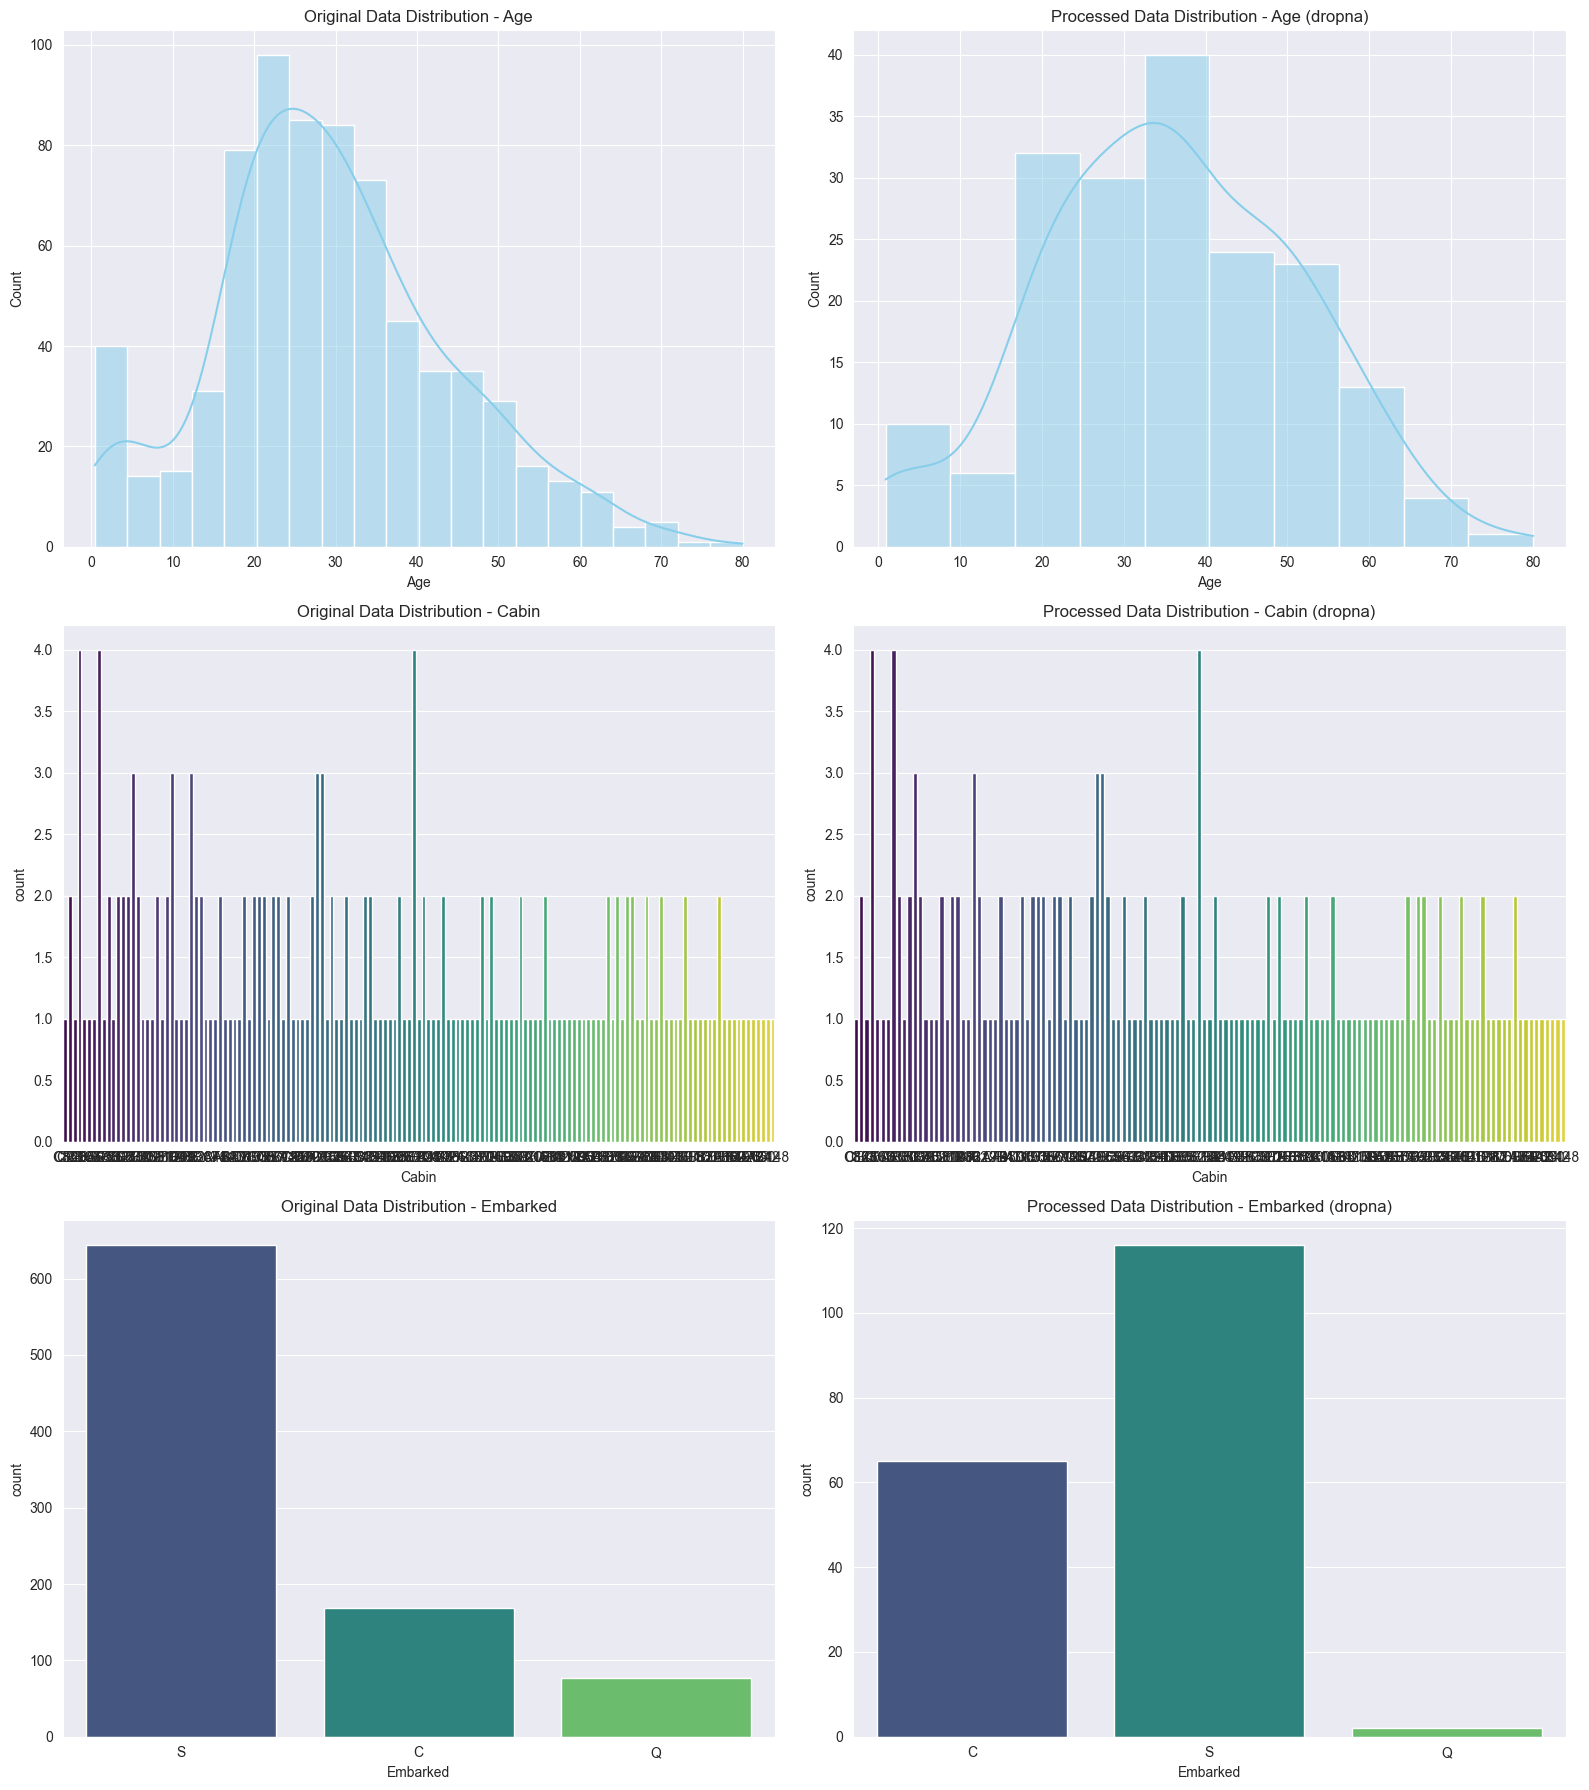

In [142]:
df = pd.read_csv("../input/titanic.csv")
print("Before dropping rows:", len(df))  # 输出删除前的行数
# 删除所有含缺失值的行
df_dropped = df.dropna()
print("After dropping rows:", len(df_dropped))  # 输出删除后的行数
visualize_missing_data_effect(df, df_dropped, method_name="dropna")


## 2.2 填充

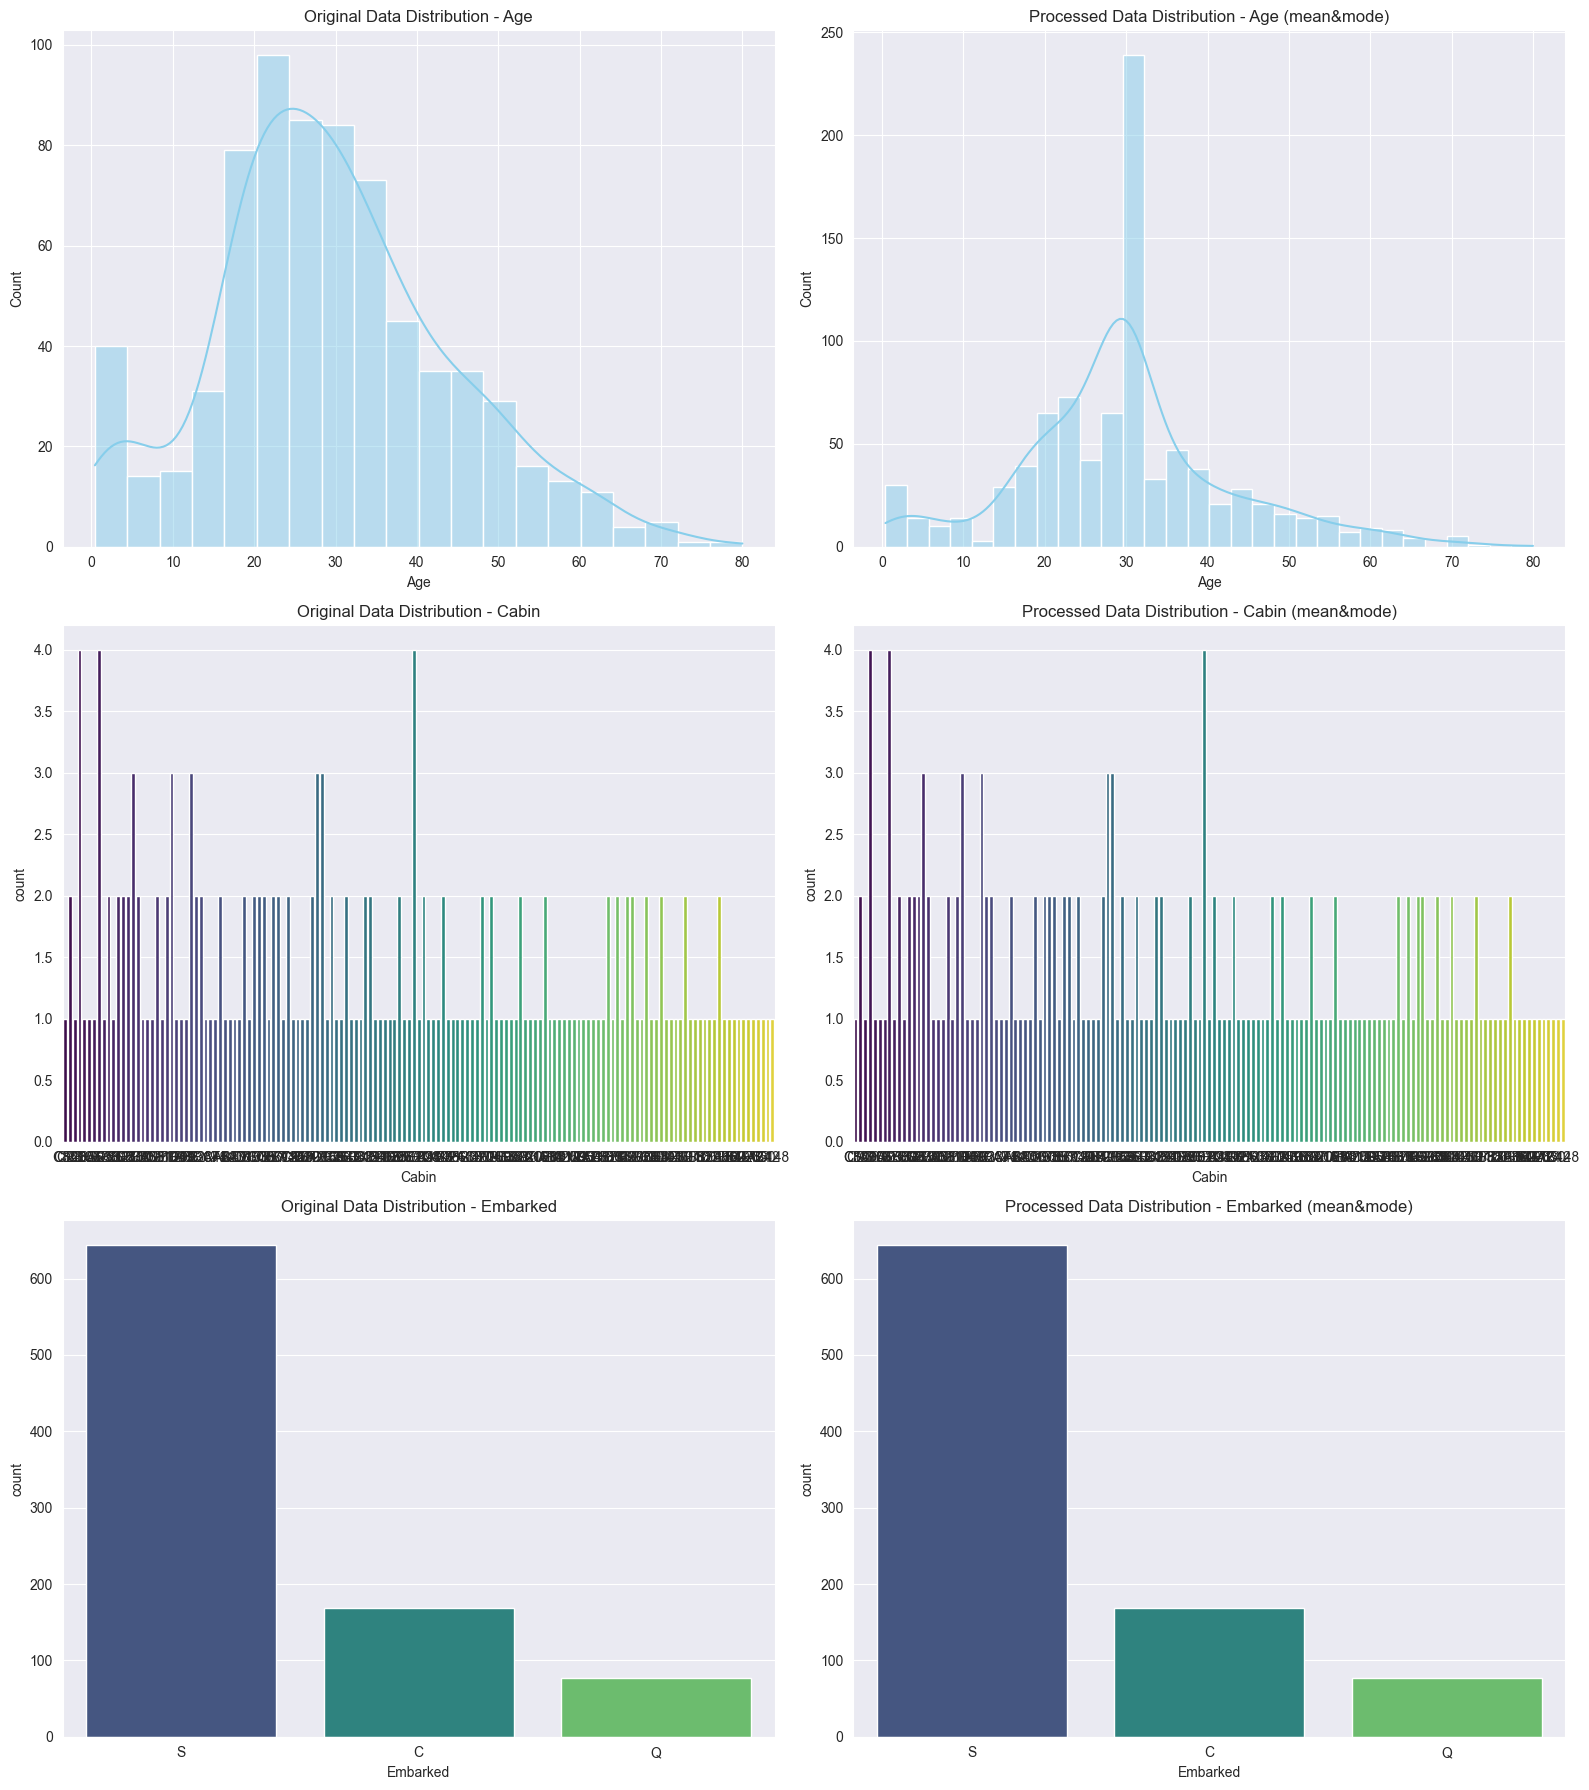

In [143]:
df = pd.read_csv("../input/titanic.csv")
# 均值填充 Age 列
df_filled_mean = df.copy()
df_filled_mean['Age'].fillna(df['Age'].mean(), inplace=True)

# 众数填充 Embarked 列
df_filled_mode = df.copy()
df_filled_mode['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)

visualize_missing_data_effect(df, df_filled_mean, method_name="mean&mode")


## 2.3 插值 MICE

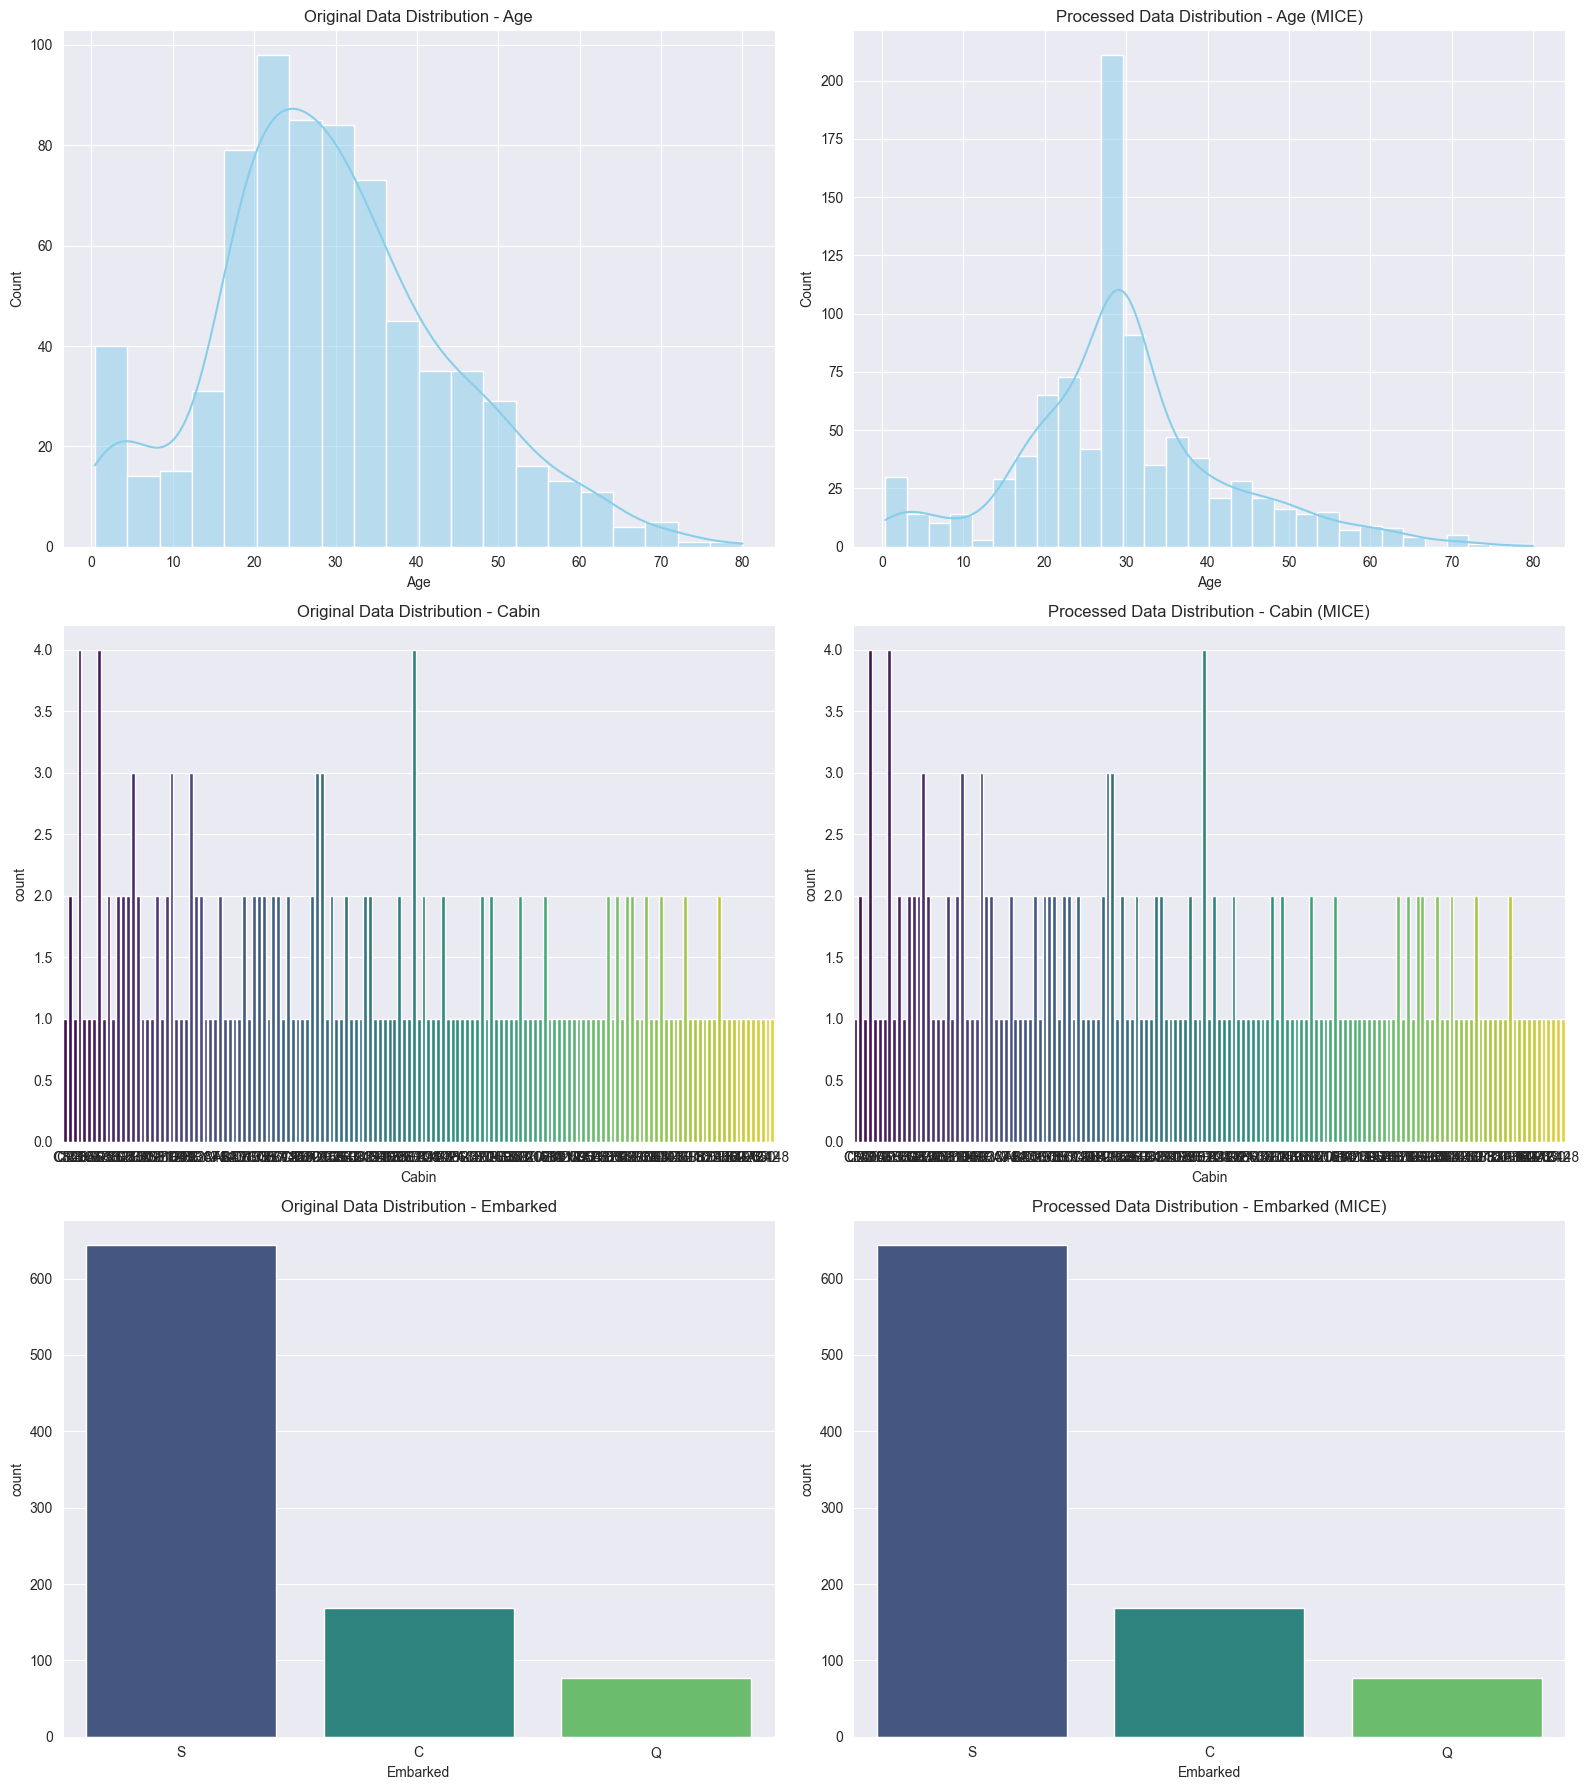

In [144]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
df = pd.read_csv("../input/titanic.csv")
# 定义 MICE 插补器
mice_imputer = IterativeImputer(estimator=BayesianRidge(), max_iter=10, random_state=0)
df_mice = df.copy()
df_mice[['Age', 'Fare']] = mice_imputer.fit_transform(df[['Age', 'Fare']])

visualize_missing_data_effect(df, df_mice, method_name="MICE")


## 2.4 回归预测

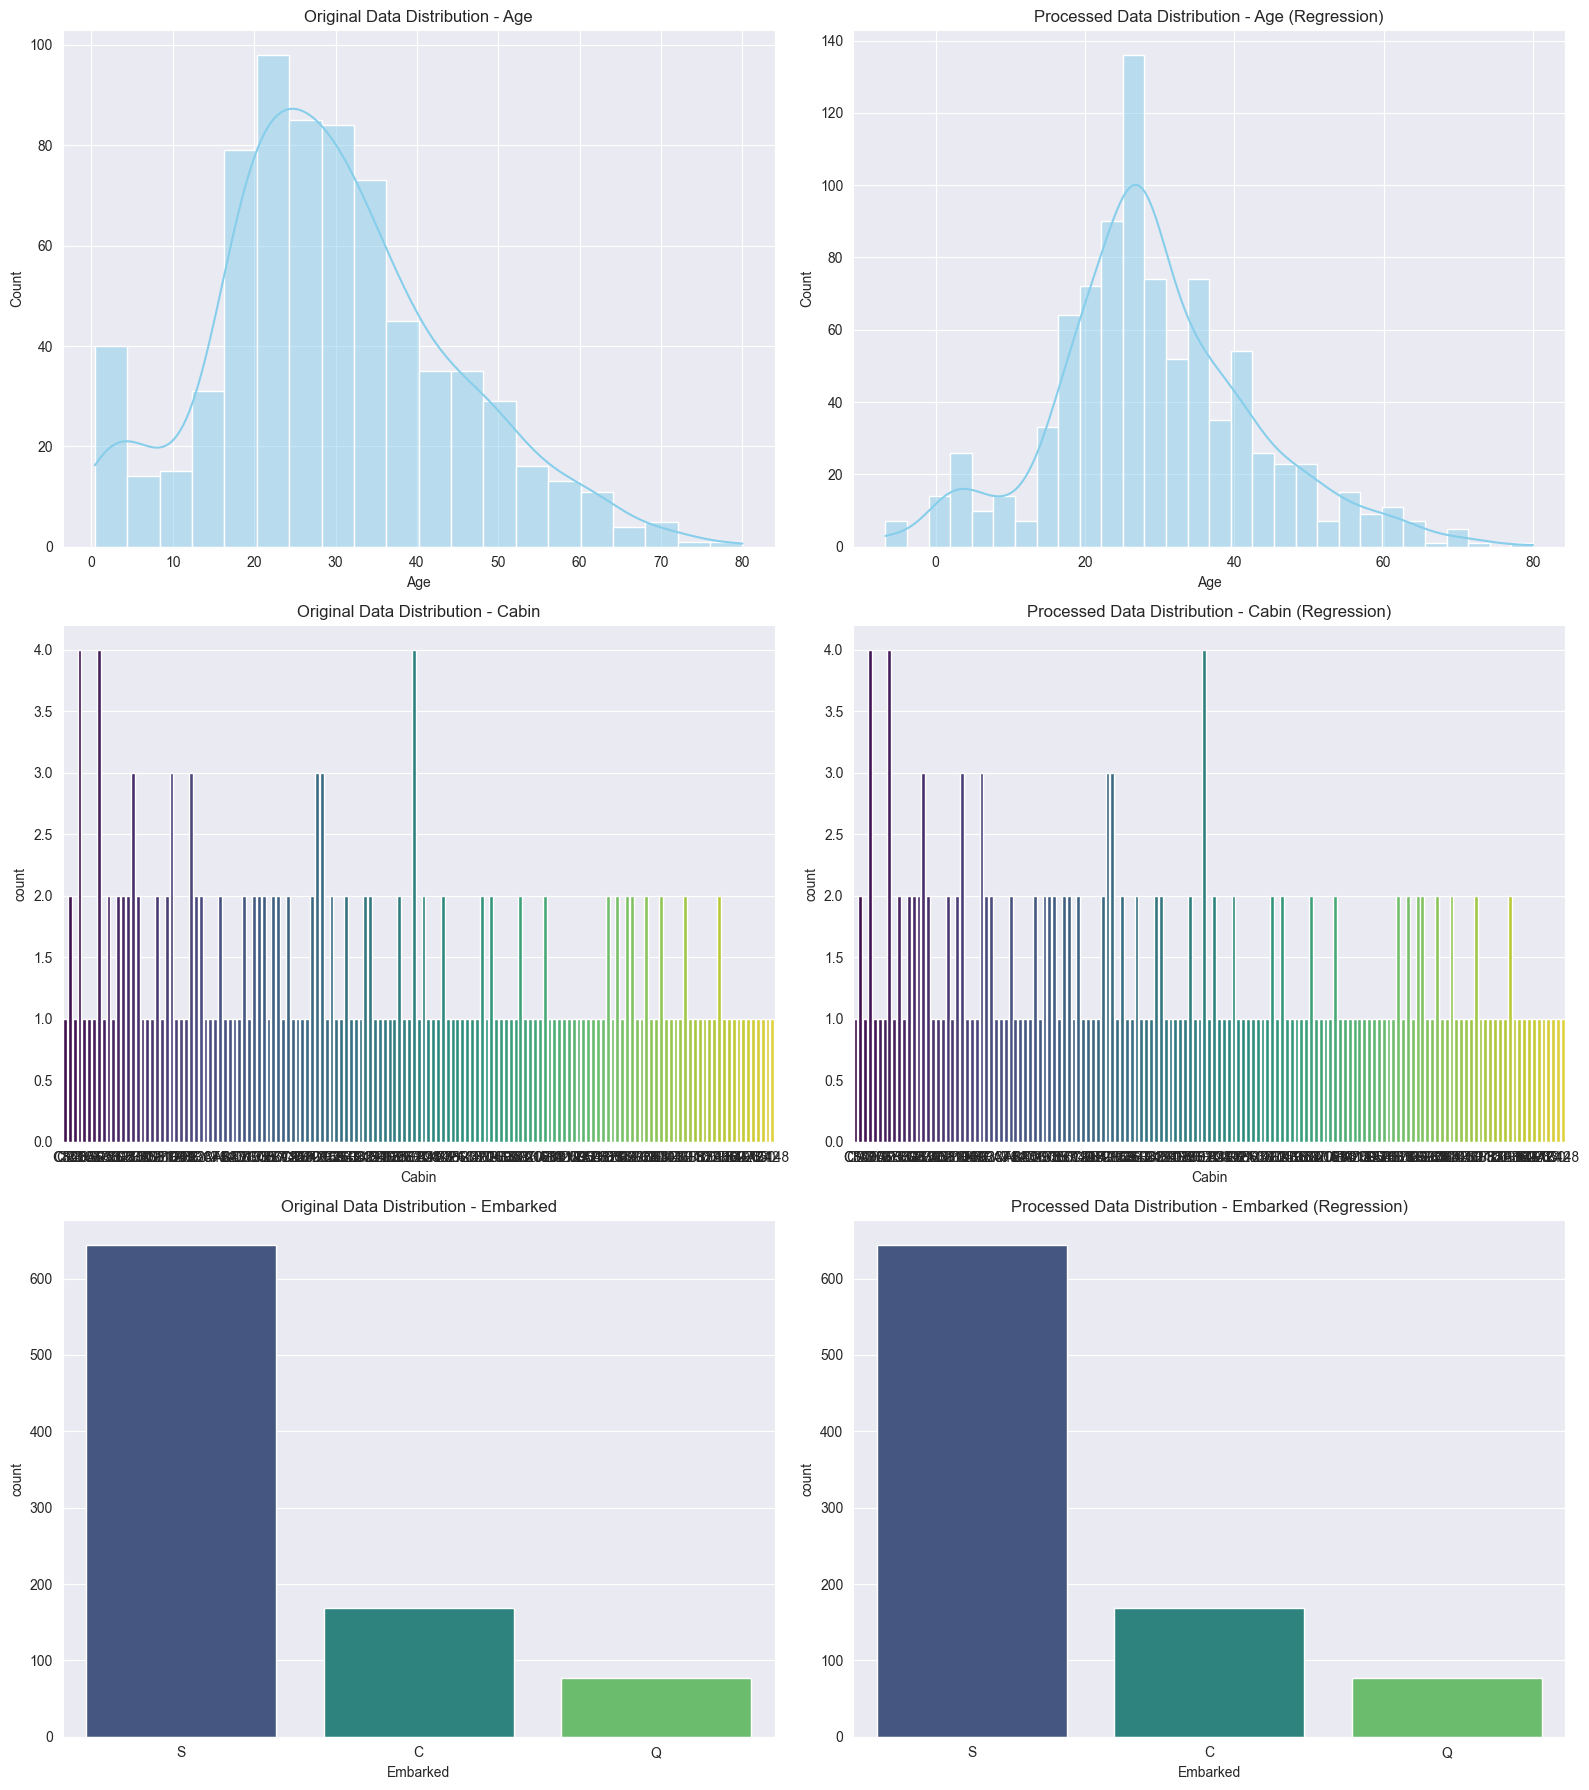

In [145]:
from sklearn.linear_model import LinearRegression
df = pd.read_csv("../input/titanic.csv")
# 使用其他特征预测 Age 的缺失值
df_regression = df.copy()
known_age = df_regression[df_regression['Age'].notna()]
unknown_age = df_regression[df_regression['Age'].isna()]

# 定义回归模型
regressor = LinearRegression()
regressor.fit(known_age[['Pclass', 'Fare', 'SibSp', 'Parch']], known_age['Age'])

# 预测缺失值
predicted_ages = regressor.predict(unknown_age[['Pclass', 'Fare', 'SibSp', 'Parch']])
df_regression.loc[df_regression['Age'].isna(), 'Age'] = predicted_ages

visualize_missing_data_effect(df, df_regression, method_name="Regression")


## 2.5 敏感性分析

问的GPT感觉还是挺扯淡的，以后再看看有没有好的方法

In [146]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score

# 读取数据
data = pd.read_csv("../input/titanic.csv")

# 创建两种缺失模式数据集
data_with_missing_1 = data.copy()
data_with_missing_2 = data.copy()

# 模式1：年龄 > 50 或 < 20 的行中随机设置 50% 的 'Age' 缺失
age_above_50_below_20 = data_with_missing_1[(data_with_missing_1['Age'] > 50) | (data_with_missing_1['Age'] < 20)].index
np.random.seed(42)
missing_indices_1 = np.random.choice(age_above_50_below_20, size=int(len(age_above_50_below_20) * 0.5), replace=False)
data_with_missing_1.loc[missing_indices_1, 'Age'] = np.nan

# 模式2：年龄在 20 到 50 之间的行中随机设置 50% 的 'Age' 缺失
age_between_20_50 = data_with_missing_2[(data_with_missing_2['Age'] >= 20) & (data_with_missing_2['Age'] <= 50)].index
np.random.seed(42)
missing_indices_2 = np.random.choice(age_between_20_50, size=int(len(age_between_20_50) * 0.5), replace=False)
data_with_missing_2.loc[missing_indices_2, 'Age'] = np.nan

# 填补缺失值（用中位数填充）
data['Age'].fillna(data['Age'].median(), inplace=True)
data_with_missing_1['Age'].fillna(data_with_missing_1['Age'].median(), inplace=True)
data_with_missing_2['Age'].fillna(data_with_missing_2['Age'].median(), inplace=True)

# 准备数据集
X_original = data.drop(['Survived'], axis=1).select_dtypes(include=[np.number])
y_original = data['Survived']
X_missing_1 = data_with_missing_1.drop(['Survived'], axis=1).select_dtypes(include=[np.number])
y_missing_1 = data_with_missing_1['Survived']
X_missing_2 = data_with_missing_2.drop(['Survived'], axis=1).select_dtypes(include=[np.number])
y_missing_2 = data_with_missing_2['Survived']

# 分割训练集和测试集
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X_original, y_original, test_size=0.2, random_state=42)
X_train_miss1, X_test_miss1, y_train_miss1, y_test_miss1 = train_test_split(X_missing_1, y_missing_1, test_size=0.2, random_state=42)
X_train_miss2, X_test_miss2, y_train_miss2, y_test_miss2 = train_test_split(X_missing_2, y_missing_2, test_size=0.2, random_state=42)

# 初始化模型
model = RandomForestClassifier(random_state=42)

# 训练并评估原始数据集模型
model.fit(X_train_orig, y_train_orig)
y_pred_orig = model.predict(X_test_orig)
y_pred_prob_orig = model.predict_proba(X_test_orig)[:, 1]

accuracy_orig = accuracy_score(y_test_orig, y_pred_orig)
f1_orig = f1_score(y_test_orig, y_pred_orig)
precision_orig = precision_score(y_test_orig, y_pred_orig)
recall_orig = recall_score(y_test_orig, y_pred_orig)
auc_orig = roc_auc_score(y_test_orig, y_pred_prob_orig)

# 训练并评估含缺失模式1的数据集模型
model.fit(X_train_miss1, y_train_miss1)
y_pred_miss1 = model.predict(X_test_miss1)
y_pred_prob_miss1 = model.predict_proba(X_test_miss1)[:, 1]

accuracy_miss1 = accuracy_score(y_test_miss1, y_pred_miss1)
f1_miss1 = f1_score(y_test_miss1, y_pred_miss1)
precision_miss1 = precision_score(y_test_miss1, y_pred_miss1)
recall_miss1 = recall_score(y_test_miss1, y_pred_miss1)
auc_miss1 = roc_auc_score(y_test_miss1, y_pred_prob_miss1)

# 训练并评估含缺失模式2的数据集模型
model.fit(X_train_miss2, y_train_miss2)
y_pred_miss2 = model.predict(X_test_miss2)
y_pred_prob_miss2 = model.predict_proba(X_test_miss2)[:, 1]

accuracy_miss2 = accuracy_score(y_test_miss2, y_pred_miss2)
f1_miss2 = f1_score(y_test_miss2, y_pred_miss2)
precision_miss2 = precision_score(y_test_miss2, y_pred_miss2)
recall_miss2 = recall_score(y_test_miss2, y_pred_miss2)
auc_miss2 = roc_auc_score(y_test_miss2, y_pred_prob_miss2)

# 输出结果
print("原始数据集：")
print(f"准确率: {accuracy_orig:.4f}")
print(f"F1分数: {f1_orig:.4f}")
print(f"精确率: {precision_orig:.4f}")
print(f"召回率: {recall_orig:.4f}")
print(f"AUC: {auc_orig:.4f}")

print("\n缺失模式1（年龄 > 50 或 < 20）：")
print(f"准确率: {accuracy_miss1:.4f}")
print(f"F1分数: {f1_miss1:.4f}")
print(f"精确率: {precision_miss1:.4f}")
print(f"召回率: {recall_miss1:.4f}")
print(f"AUC: {auc_miss1:.4f}")

print("\n缺失模式2（年龄在 20 到 50 之间）：")
print(f"准确率: {accuracy_miss2:.4f}")
print(f"F1分数: {f1_miss2:.4f}")
print(f"精确率: {precision_miss2:.4f}")
print(f"召回率: {recall_miss2:.4f}")
print(f"AUC: {auc_miss2:.4f}")


原始数据集：
准确率: 0.7151
F1分数: 0.6383
精确率: 0.6716
召回率: 0.6081
AUC: 0.8099

缺失模式1（年龄 > 50 或 < 20）：
准确率: 0.6983
F1分数: 0.6087
精确率: 0.6562
召回率: 0.5676
AUC: 0.7825

缺失模式2（年龄在 20 到 50 之间）：
准确率: 0.7318
F1分数: 0.6571
精确率: 0.6970
召回率: 0.6216
AUC: 0.7958


In [147]:
import pandas as pd
from scipy.stats import chi2_contingency

# 加载数据
data = pd.read_csv("../input/titanic.csv")

# 计算总缺失值数量
total_missing = data['Age'].isnull().sum()

# 分组：年龄大于50岁和小于20岁
grouped = data.groupby((data['Age'] > 50) | (data['Age'] < 20))

# 计算每组的缺失值数量
missing_values = grouped['Age'].apply(lambda x: x.isnull().sum())

# 计算每组的样本数量
sample_sizes = grouped['Age'].apply(len)

# 创建列联表
contingency_table = pd.DataFrame({
    'Age > 50 or Age < 20': [missing_values[True], sample_sizes[True] - missing_values[True]],
    'Age 20 ≤ Age ≤ 50': [missing_values[False], sample_sizes[False] - missing_values[False]]
})

# 执行卡方检验
chi2, p, dof, expected = chi2_contingency(contingency_table)

# 打印结果
print(f"总缺失值数量: {total_missing}")
print(f"缺失值数量（年龄>50或年龄<20）: {missing_values[True]}")
print(f"缺失值数量（年龄20≤50）: {missing_values[False]}")
print(f"样本数量（年龄>50或年龄<20）: {sample_sizes[True]}")
print(f"样本数量（年龄20≤50）: {sample_sizes[False]}")
print(f"卡方值: {chi2}")
print(f"P值: {p}")

总缺失值数量: 177
缺失值数量（年龄>50或年龄<20）: 0
缺失值数量（年龄20≤50）: 177
样本数量（年龄>50或年龄<20）: 228
样本数量（年龄20≤50）: 663
卡方值: 74.2903129516547
P值: 6.743360131826375e-18


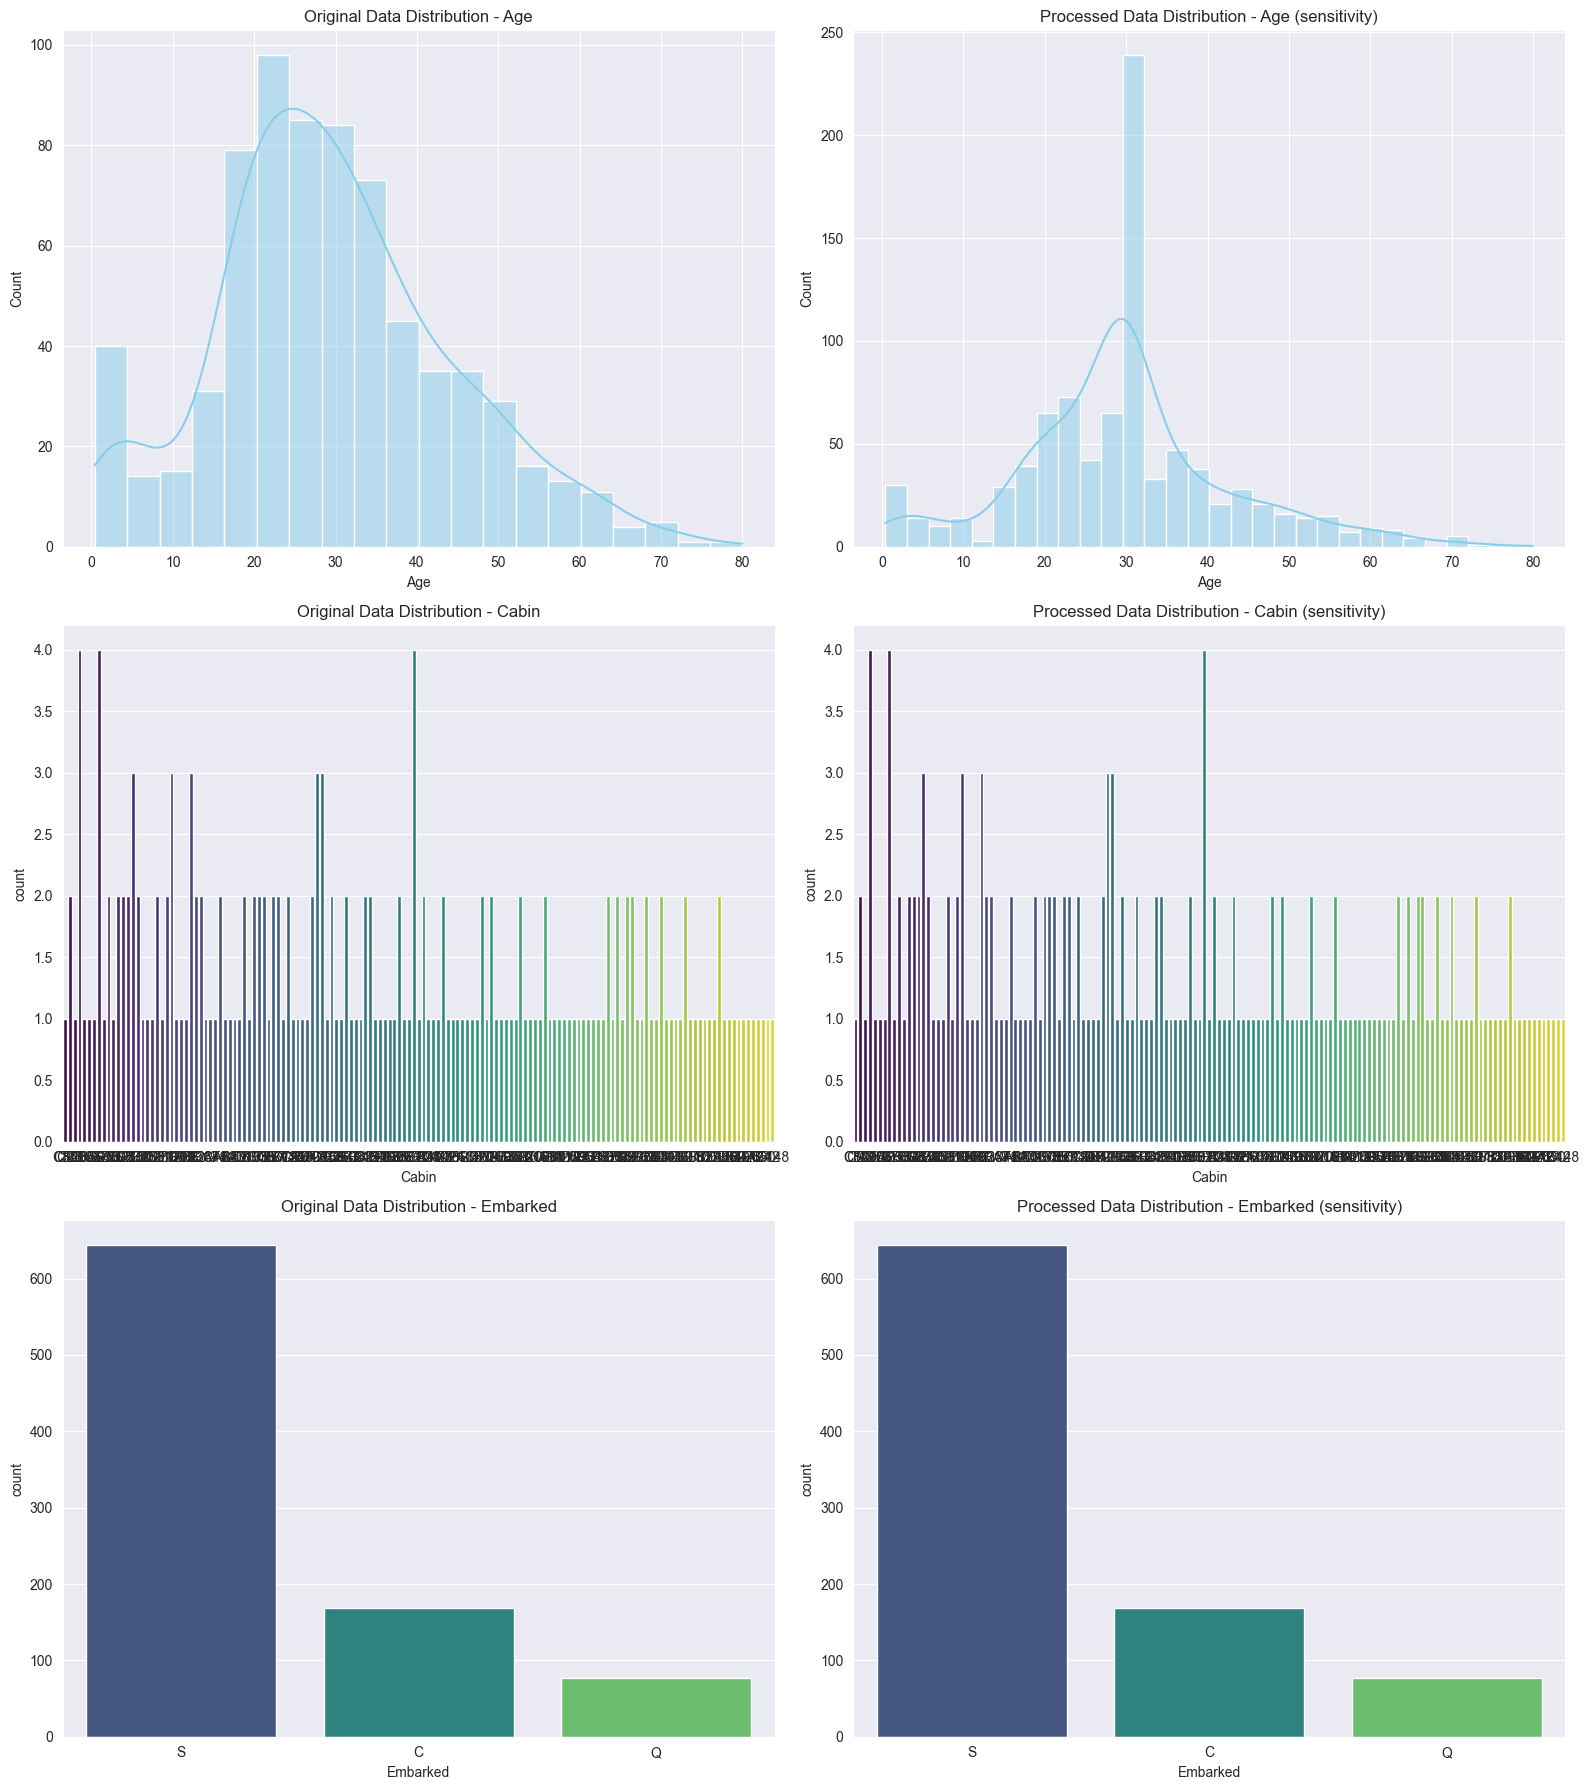

In [148]:
# 敏感性分析通常需要定义不同的缺失数据假设，并比较结果
# 这里我们假设'Cabin'是缺失的，并且与'Survived'有关
# 我们可以通过改变'Cabin'的缺失值来观察结果的变化

# 定义一个函数来模拟不同的缺失数据假设
def sensitivity_analysis(df, variable, threshold):
    df = df.copy()
    # 假设高于某个阈值的收入缺失
    df[variable] = df[variable].fillna(df[variable].mean())
    df.loc[df[variable] > threshold, variable] = np.nan
    # 这里可以添加模型训练和评估的代码
    # 比较不同阈值下的模型结果
    return df

# 调用函数进行敏感性分析
df_sensitivity = sensitivity_analysis(df, 'Age', 10000)

visualize_missing_data_effect(df, df_sensitivity, method_name="sensitivity")